In [28]:
import matplotlib.pyplot as pyplot
import json
from functools import reduce
from timeit import default_timer as timer
from heapq import heappop, heappush
from copy import copy, deepcopy

# Problema de cautare in spatiul starilor

## Cerinta 1


Definire reprezentare problema.

In [29]:
# Define how a problem is represented 
problems = []

# For each problem, a tuple (NAME, WIDTH, HEIGHT, ROWS, COLUMNS)
NAME = 0
WIDTH = 1
HEIGHT = 2
ROWS = 3
COLUMNS = 4

In [30]:
#Read the input information

for i in [1, 2, 3, 4, 5, 6]:
    f = open('Teste/test' + str(i) + '.json',)
    input_info = json.load(f)
    f.close()
    problems.append((input_info['name'], input_info['width'], input_info['height'], input_info['rows'], input_info['columns']))

def solve_problem(problem_nr, algorithm_name, algorithm, heuristic = None):
    if heuristic is None:
        start_time = timer()
        sol = algorithm(problems[problem_nr])
        end_time = timer()
    else:
        start_time = timer()
        sol = algorithm(heuristic, problems[problem_nr])
        end_time = timer()
    

    %matplotlib inline
    pyplot.imshow(sol[2], cmap='Greys', interpolation='nearest');

    print('Nodes Generated: ' + str(sol[0]))
    print('Nodes Expanded: ' + str(sol[1]))
    print('Time: ' + str(end_time - start_time) + 's')

    sol_json = {
        'strategy': algorithm_name,
        'nodes generated': sol[0],
        'nodes expanded': sol[1],
        'time': end_time - start_time,
        'solution': sol[2]
    }

    cout = open("problema" + str(problem_nr) + ".out", "a")
    json.dump(sol_json, cout)
    cout.close()


In [31]:
# Each node will be representet as a tuple (CONFIGURATION, ROW) and will
# track how the configuration looks for the first ROW rows

CONFIGURATION = 0
ROW = 1

# Each cell can be white, black, or unknown
WHITE = 0
BLACK = 1
UNKNOWN = 2

In [32]:
# Function is used for evaluating if the configuration is final on 
# a certain column and also for generating next configurations on that column. 
# Illegal configurations can't be neighbours with the previous configuration
def check_collumn(configuration, col, check_height, is_final_check, problem):
    component = 0
    start = -1
    end = -1
    nr_blocks = 0
    
    for i in range(0, check_height):
        if configuration[i][col] == BLACK:
            nr_blocks += 1
            if start == -1:
                start = i
        else:
            if start != -1:
                end = i - 1
                component += 1
                if component > len(problem[COLUMNS][col]):
                    return False
                if end - start + 1 != problem[COLUMNS][col][component - 1]:
                    return False
                start = -1
                end = -1
    
    # If the last component lasted until the end of the columns,
    # take that component into account
    if start != -1:
        end = check_height - 1
        component += 1
    
    # If it is the final_check, then the number of components fould should be
    # the same with the number of expected components
    if is_final_check and component != len(problem[COLUMNS][col]):
        return False
    
    if problem[COLUMNS][col] and start != -1:
        if is_final_check and problem[COLUMNS][col][component - 1] != end - start + 1:
            return False
        if not is_final_check:
            # If is not the final check and we have found more components than in the
            # expected config, then this move is illegal and it means this state can't be
            # neighbour with the last one
            if component > len(problem[COLUMNS][col]):
                return False
            
            # If is not the final check, if the current component contains more 
            # elements than the corresponding component in the expected config, this
            # means that this state can't be a neighbour of the current state, since
            # the move is illegal
            if problem[COLUMNS][col][component - 1] < end - start + 1:
                return False
    
    # If is not the final check and there is no room left for the others components
    # to be added, it means this configuration is not neighbour with the last one
    if not is_final_check:
        expected_nr_blocks = reduce(lambda sum, x: sum + x, problem[COLUMNS][col], 0)
        need_next = expected_nr_blocks - nr_blocks + len(problem[COLUMNS][col]) - component - 1
        if need_next > problem[HEIGHT] - check_height:
            return False
    
    return True

# Function is used for evaluating if the configuration is final and also 
# for generating next configurationn. Illegal configurations can't be neighbours
# with the previous configuration
def check_collumns(configuration, check_height, is_final_check, problem):
    return reduce(
        lambda so_far, col: so_far and check_collumn(configuration, col, check_height, is_final_check, problem), 
        list(range(0, problem[WIDTH])), 
        True
    )

# Returns True if the current node is final
def is_final(node, problem):
    return (node[ROW] == problem[HEIGHT] - 1) and check_collumns(node[CONFIGURATION], problem[HEIGHT], True, problem)


In [33]:
# Generate a line from the specified components within a problem
def generate_line(line_components, width):
    nr_components = len(line_components)
    
    dp = [[[] for c in range(width + 2)] for r in range(nr_components + 1)]
    dp[nr_components] = [[[0 for e in range(width)]] for c in range(width + 2)]
    
    for i in reversed(range(0, nr_components)):
        component_length = line_components[i]
        for j in reversed(range(0, width - component_length + 1)):
            dp[i][j].extend(dp[i][j + 1])
            for partial in dp[i + 1][j + component_length + 1]:
                partial_copy = partial[:]
                for step in range(0, component_length):
                    partial_copy[j + step] = 1
                dp[i][j].append(partial_copy)
            
    return dp[0][0]


# Map that keeps track of the line generated, to elimante the overhead
# of generating the same line twice
known_configurations = {}
for problem in problems:
    known_configurations[problem[NAME]] = {}

def get_neighbours_row(node, problem):
    row = node[ROW] + 1
    if row >= problem[HEIGHT]:
        return []
    
    if known_configurations[problem[NAME]].get(tuple(problem[ROWS][row])) is not None:
        next_configurations = known_configurations[problem[NAME]].get(tuple(problem[ROWS][row]))
    else:
        next_configurations = generate_line(problem[ROWS][row], problem[WIDTH])
        known_configurations[problem[NAME]][tuple(problem[ROWS][row])] = next_configurations
    
    return list(map(
        lambda config : (config, row),
        list(filter(
            lambda config : check_collumns(config, row + 1, False, problem), 
            list(map(lambda new_line : node[CONFIGURATION][:] + [new_line], next_configurations))
        ))))



## Cerinta 2


Strategii de cautare neinformata.

### Breadth First Search


In [34]:
def bfs(problem):
    start = ([], -1)
    queue = []
    
    generated = 1
    expanded = 0
    
    queue.append(start)
    
    while queue:
        current_state = queue.pop(0)
        expanded += 1
        
        neighbours = get_neighbours_row(current_state, problem)
        generated += len(neighbours)
        
        for neighbour in neighbours:
            if is_final(neighbour, problem):
                return (generated, expanded, neighbour[CONFIGURATION])
            queue.append(neighbour)
    
        
    
    

Nodes Generated: 11
Nodes Expanded: 8
Time: 0.0012655720020120498s


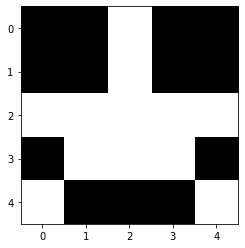

In [77]:
# BFS Problema 1
solve_problem(0, 'Breadth First Search', bfs)

Nodes Generated: 6
Nodes Expanded: 5
Time: 0.0010464849983691238s


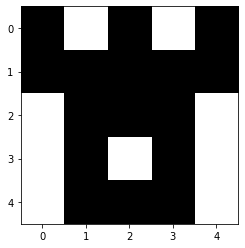

In [78]:
# BFS Problema 2
solve_problem(1, 'Breadth First Search', bfs)

Nodes Generated: 43
Nodes Expanded: 42
Time: 0.04715419999774895s


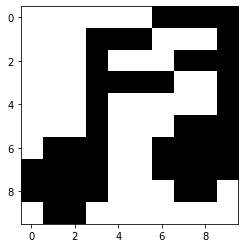

In [79]:
# BFS Problema 3
solve_problem(2, 'Breadth First Search', bfs)

Nodes Generated: 545
Nodes Expanded: 540
Time: 2.8964887680012907s


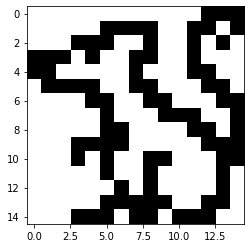

In [80]:
# BFS Problema 4
solve_problem(3, 'Breadth First Search', bfs)

Nodes Generated: 26164
Nodes Expanded: 26163
Time: 129.91471560900027s


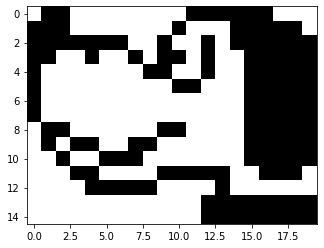

In [81]:
# BFS Problema 5
solve_problem(4, 'Breadth First Search', bfs)

Nodes Generated: 154
Nodes Expanded: 153
Time: 17.92701210499945s


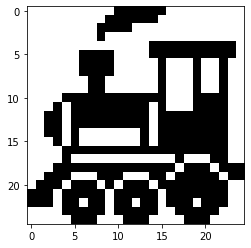

In [82]:
# BFS Problema 6
solve_problem(5, 'Breadth First Search', bfs)

### Depth First Search


In [35]:
def dfs(problem):
    start = ([], -1)
    stack = []
    
    generated = 1
    expanded = 0
    
    stack.append(start)
    
    while stack:
        current_state = stack.pop()
        expanded += 1
        
        neighbours = get_neighbours_row(current_state, problem)
        generated += len(neighbours)
        
        for neighbour in neighbours:
            if is_final(neighbour, problem):
                return (generated, expanded, neighbour[CONFIGURATION])
            stack.append(neighbour)

Nodes Generated: 11
Nodes Expanded: 7
Time: 0.0010713539995776955s


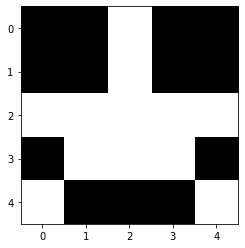

In [85]:
# DFS Problema 1
solve_problem(0, 'Depth First Search', dfs)

Nodes Generated: 6
Nodes Expanded: 5
Time: 0.000717261998943286s


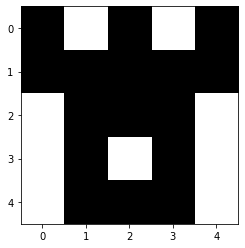

In [86]:
# DFS Problema 2
solve_problem(1, 'Depth First Search', dfs)

Nodes Generated: 43
Nodes Expanded: 42
Time: 0.04506557200147654s


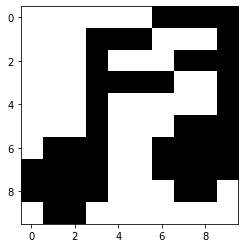

In [87]:
# DFS Problema 3
solve_problem(2, 'Depth First Search', dfs)

Nodes Generated: 534
Nodes Expanded: 527
Time: 2.2055133300018497s


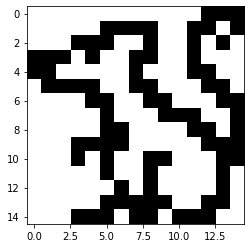

In [88]:
# DFS Problema 4
solve_problem(3, 'Depth First Search', dfs)

Nodes Generated: 10427
Nodes Expanded: 10329
Time: 108.65123663600025s


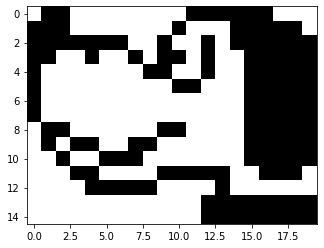

In [89]:
# DFS Problema 5
solve_problem(4, 'Depth First Search', dfs)

Nodes Generated: 126
Nodes Expanded: 110
Time: 13.62412197500089s


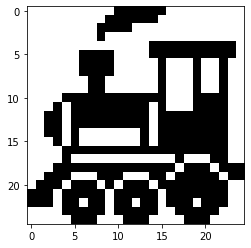

In [90]:
# DFS Problema 6
solve_problem(5, 'Depth First Search', dfs)

### Iterative deepening search

In [118]:
def dfs_ad_max(ad_max, problem):
    start = ([], -1)
    OPEN = []
    
    generated = 1
    expanded = 0
    
    OPEN.append(start)
    
    while OPEN:
        current_state = OPEN.pop()
        
        if is_final(current_state, problem):
                return (generated, expanded, neighbour[CONFIGURATION])
        if current_state[ROW] > ad_max:
            return (generated, expanded, None)
        
        expanded += 1
        neighbours = get_neighbours_row(current_state, problem)
        generated += len(neighbours)
        
        for neighbour in neighbours:
            OPEN.append(neighbour)
    return (generated, expanded, None)


def iterative_deepening(problem):
    ad_max = 0
    generated = 0
    expanded = 0
    
    while True:
        result =  dfs_ad_max(ad_max, problem)
        generated += result[0]
        expanded += result[1]
        if result[2] is not None:
            return (generated, expanded, result[2])
        ad_max += 1
        

Nodes Generated: 28
Nodes Expanded: 16
Time: 0.002153761000954546s


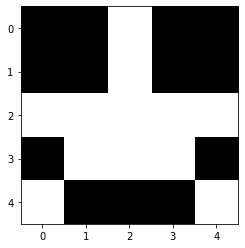

In [119]:
# Iterative Deepening Problema 1
solve_problem(0, 'Iterative deepening search', iterative_deepening)

Nodes Generated: 18
Nodes Expanded: 14
Time: 0.003794346994254738s


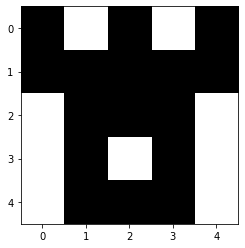

In [120]:
# Iterative Deepening Problema 2
solve_problem(1, 'Iterative deepening search', iterative_deepening)

Nodes Generated: 326
Nodes Expanded: 305
Time: 0.27334024899755605s


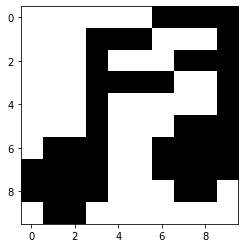

In [121]:
# Iterative Deepening Problema 3
solve_problem(2, 'Iterative deepening search', iterative_deepening)

Nodes Generated: 5169
Nodes Expanded: 5026
Time: 10.70187609399727s


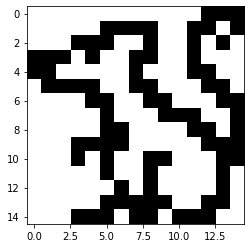

In [122]:
# Iterative Deepening Problema 4
solve_problem(3, 'Iterative deepening search', iterative_deepening)

Nodes Generated: 34502
Nodes Expanded: 33551
Time: 172.36137605500699s


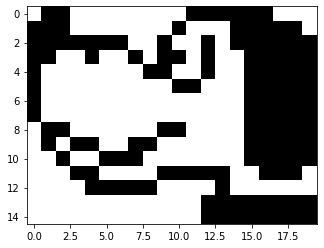

In [123]:
# Iterative Deepening Problema 5
solve_problem(4, 'Iterative deepening search', iterative_deepening)

Nodes Generated: 2109
Nodes Expanded: 1724
Time: 86.25188750198868s


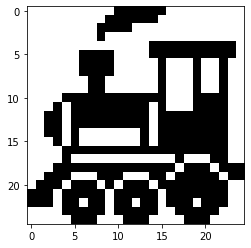

In [124]:
# Iterative Deepening Problema 6
solve_problem(5, 'Iterative deepening search', iterative_deepening)

## Cerinta 3
### A* Search

In [37]:
# Check if the current line matches the mask.
def match_line(mask, possible_line):
    for i in range(len(mask)):
        if mask[i] == BLACK and possible_line[i] == WHITE:
            return False
        if mask[i] == WHITE and possible_line[i] == BLACK:
            return False
    return True

# Helper function to overlap to possible configurations.
def find_unknown(line_so_far, line):
    for i in range(len(line_so_far)):
        if line_so_far[i] != line[i]:
            line_so_far[i] = UNKNOWN
    return line_so_far

# Computes the mask of a line and returns the configurations that comply to the
# mask. Mask is computed as follows: if a block can be both white or black, 
# then the mask has UNKNOWN for that position. Otherwise, BLACK or WHITE is stored
def get_line_information(line, possible_lines):
    match_restriction = list(filter(
        lambda possible_line: match_line(line, possible_line),
        possible_lines
    ))
    
    if match_restriction:
        return (reduce(find_unknown, match_restriction, match_restriction[0].copy()),  match_restriction)
    else:
        return ([], [])

known_columns_config = {}
for problem in problems:
    known_columns_config[problem[NAME]] = {}

# h1 computes how many cells are left to be guessed supposing the cells in mask 
# have been guessed correctly
def h1(node, mask, problem):
    known_found = 0
    for i in range(problem[WIDTH]):
        if mask[i] == UNKNOWN:
            column = [UNKNOWN for i in range(problem[HEIGHT])]
            for j in range(node[ROW] + 1):
                column[j] = node[CONFIGURATION][j][i]
                
            if known_columns_config[problem[NAME]].get(tuple(problem[COLUMNS][i])) is not None:
                column_configs = known_columns_config[problem[NAME]].get(tuple(problem[COLUMNS][i])) 
            else:
                column_configs = generate_line(problem[COLUMNS][i], problem[HEIGHT])
                known_columns_config[problem[NAME]][tuple(problem[COLUMNS][i])] = column_configs
           
            (column_mask, possibilities) = get_line_information(column, column_configs)
            
            if not possibilities:
                return ERROR
            else:
                known_found += (node[ROW] + 1) - (problem[HEIGHT] - column_mask.count(UNKNOWN))
    return (problem[HEIGHT] - (node[ROW] + 1) ) * problem[WIDTH] - known_found 

# h2 computes how many cells are left to be guessed if the black cells
# uniquely determine all the other cells in that collumn
def h2(node, mask, problem):
    contribute = 0
    
    for col in range(problem[WIDTH]):
        expected_col = reduce(lambda sum, x: x + sum + 1, problem[COLUMNS][col])
        already = 0;
        for row in range(len(node[CONFIGURATION])):
            if node[CONFIGURATION][row][col] == BLACK:
                already += 1
        contribute += expected_col - already
    return (problem[HEIGHT] - len(node[CONFIGURATION])) * problem[WIDTH] - contribute
            
            
def astar(h, problem):
    start = ([], -1, 0)
    
    frontier = []
    heappush(frontier, (0 + problem[HEIGHT] * problem[WIDTH], start))
    
    expanded = 0
    generated = 1
    
    exp = 0;
    while frontier:
        (f_current, node) = heappop(frontier)
        expanded += 1
        
        neighbours = get_neighbours_row(node, problem)
        generated += len(neighbours)
        
        possibilities = [neighbours[i][CONFIGURATION][node[ROW] + 1] for i in range(len(neighbours))]
        (line_mask, _) = get_line_information([UNKNOWN for i in range(problem[WIDTH])], possibilities)
        
        for neighbour in neighbours:
            if is_final(neighbour, problem):
                return (generated, expanded, neighbour[CONFIGURATION])
            
            g = node[2] + line_mask.count(UNKNOWN)
            h_value = h(neighbour, line_mask, problem)
            f = g + h_value
            next_node = (neighbour[CONFIGURATION], neighbour[ROW], g)
            heappush(frontier, (f, next_node))
            
        
       
            
    
    

Nodes Generated: 11
Nodes Expanded: 8
Time: 0.0028358909767121077s


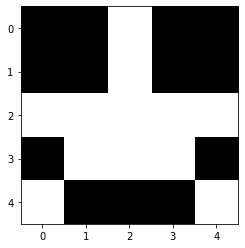

In [125]:
# A* Problema 1 cu h1
solve_problem(0, 'A* Search h1', astar, h1)

Nodes Generated: 6
Nodes Expanded: 5
Time: 0.0009304279992647935s


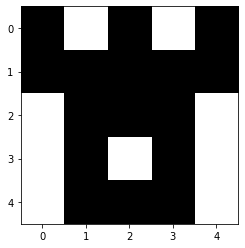

In [99]:
# A* Problema 2 cu h1
solve_problem(1, 'A* Search h1', astar, h1)

Nodes Generated: 27
Nodes Expanded: 13
Time: 0.032149712002137676s


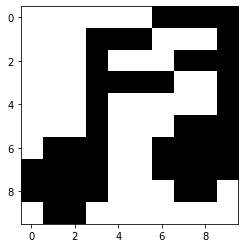

In [127]:
# A* Problema 3 cu h1
solve_problem(2, 'A* Search h1', astar, h1)

Nodes Generated: 92
Nodes Expanded: 53
Time: 1.102008415000455s


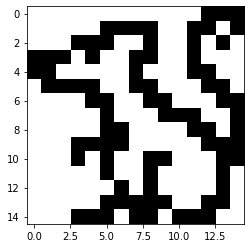

In [101]:
# A* Problema 4 cu h1
solve_problem(3, 'A* Search h1', astar, h1)

Nodes Generated: 17040
Nodes Expanded: 17000
Time: 125.44020981799986s


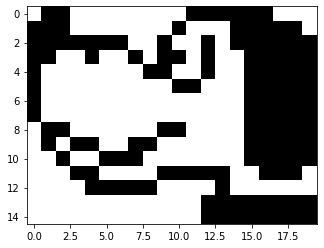

In [102]:
# A* Problema 5 cu h1
solve_problem(4, 'A* Search h1', astar, h1)

Nodes Generated: 75
Nodes Expanded: 40
Time: 5.393193780008005s


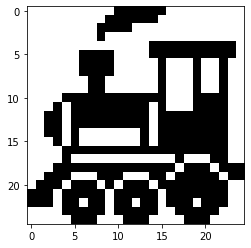

In [126]:
# A* Problema 6 cu h1
solve_problem(5, 'A* Search h1', astar, h1)

Nodes Generated: 11
Nodes Expanded: 8
Time: 0.0028157599990663584s


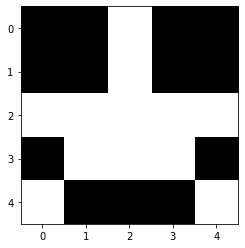

In [104]:
# A* Problema 1 cu h2
solve_problem(0, 'A* Search h2', astar, h2)

Nodes Generated: 6
Nodes Expanded: 5
Time: 0.0009706929995445535s


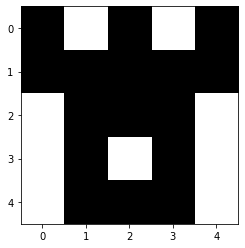

In [105]:
# A* Problema 2 cu h2
solve_problem(1, 'A* Search h2', astar, h2)

Nodes Generated: 23
Nodes Expanded: 10
Time: 0.014300252001703484s


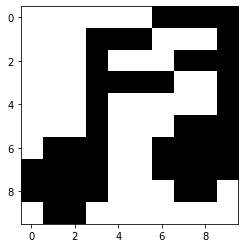

In [106]:
# A* Problema 3 cu h2
solve_problem(2, 'A* Search h2', astar, h2)

Nodes Generated: 196
Nodes Expanded: 129
Time: 0.8141792220012576s


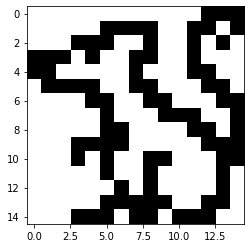

In [107]:
# A* Problema 4 cu h2
solve_problem(3, 'A* Search h2', astar, h2)

Nodes Generated: 19431
Nodes Expanded: 19172
Time: 91.08366788399871s


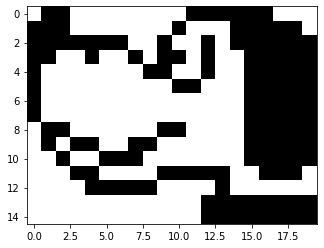

In [108]:
# A* Problema 5 cu h2
solve_problem(4, 'A* Search h2', astar, h2)

Nodes Generated: 114
Nodes Expanded: 80
Time: 6.860065481003403s


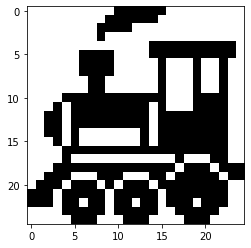

In [109]:
# A* Problema 6 cu h2
solve_problem(5, 'A* Search h2', astar, h2)

# Problema satisfacerii restrictiilor

In [101]:
LINE = 0
COL = 1

# Generate the variable and their Domains
def generate_csp(problem):
    Vars = []
    Domains = {}
    
    Vars = [(LINE, i) for i in range(problem[HEIGHT])]
    Vars.extend([(COL, i) for i in range(problem[WIDTH])])
    
    for var in Vars:
        if var[0] == LINE:
            if known_configurations[problem[NAME]].get(tuple(problem[ROWS][var[1]])) is not None:
                next_configurations = known_configurations[problem[NAME]].get(tuple(problem[ROWS][var[1]]))
            else:
                next_configurations = generate_line(problem[ROWS][var[1]], problem[WIDTH])
                known_configurations[problem[NAME]][tuple(problem[ROWS][var[1]])] = next_configurations
            
            if not next_configurations:
                next_configurations = [[0 for i in range(problem[HEIGHT])]]
            Domains[var] = next_configurations
        else:
            if known_columns_config[problem[NAME]].get(tuple(problem[COLUMNS][var[1]])) is not None:
                column_configs = known_columns_config[problem[NAME]].get(tuple(problem[COLUMNS][var[1]])) 
            else:
                column_configs = generate_line(problem[COLUMNS][var[1]], problem[HEIGHT])
                known_columns_config[problem[NAME]][tuple(problem[COLUMNS][var[1]])] = column_configs
            if not column_configs:
                column_configs = [[0 for i in range(problem[WIDTH])]]
            Domains[var] = column_configs
     
    return (Vars, Domains)

def ac3_begin(problem, Domains):
    Q = [((LINE, i), (COL, j)) for i in range(problem[HEIGHT]) for j in range(problem[WIDTH])]
    Q.extend([((COL, i), (LINE, j)) for i in range(problem[WIDTH]) for j in range(problem[HEIGHT])])
    
    while Q:
        current = Q.pop(0)
        Xk = current[0]
        Xm = current[1]
        
        if arc_reduce(Domains, Xk, Xm):
            if not Domains[Xk]:
                return False
            if Xk[0] == LINE:
                Q.extend(list(filter(lambda pair: pair[0] != Xm,  [((COL, i), Xk) for i in range(problem[WIDTH])])))
            else:
                Q.extend(list(filter(lambda pair: pair[0] != Xm,  [((LINE, i), Xk) for i in range(problem[HEIGHT])])))
                         
    return True

def ac3(problem, Domains, Solution, X, val_x):
    Domains[X] = [val_x]
    if X[0] == LINE:
        Q = list(map(
            lambda col: ((COL, col), X), 
            list(filter(
                lambda col : (COL, col) not in Solution, range(problem[WIDTH])))
        ))
    else:
        Q = list(map(
            lambda lin: ((LINE, lin), X), 
            list(filter(
                lambda lin : (LINE, lin) not in Solution, range(problem[HEIGHT])))
        ))

    
    while Q:
        current = Q.pop(0)
        Xk = current[0]
        Xm = current[1]
        
        if arc_reduce(Domains, Xk, Xm):
            if not Domains[Xk]:
                return False
            if Xk[0] == LINE:
                Q.extend(list(filter(lambda pair: pair[0] != Xm,  [((COL, i), Xk) for i in range(problem[WIDTH])])))
            else:
                Q.extend(list(filter(lambda pair: pair[0] != Xm,  [((LINE, i), Xk) for i in range(problem[HEIGHT])])))
    
    return True
            
        
def arc_reduce(Domains, X, Y):
    change = False
    new_domain = []
    for vx in Domains[X]:
        found_value = False
        for vy in Domains[Y]:
            if vx[Y[1]] == vy[X[1]]:
                found_value = True
                break;
        if not found_value:
            change = True
        else:
            new_domain.append(vx)
    
    Domains[X] = new_domain
    return change


def bkt_mac(problem, Vars, Solution, Domains):
    if not Vars:
        return (True, Solution, 1)
    
    X = Vars[0]
    expanded = 1
    
    for val in Domains[X]:
        new_Domains = deepcopy(Domains)
        if ac3(problem, new_Domains, Solution, X, val):
            new_Vars = Vars[:]
            new_Vars.pop(0)
            
            new_Solution = deepcopy(Solution)
            new_Solution[X] = val
            
            (return_value, return_Solution, return_expanded) = bkt_mac(problem, new_Vars, new_Solution, new_Domains)
            expanded += return_expanded
            
            if return_value:
                return (return_value, return_Solution, expanded)
    
    return (False, {}, 1)

def mac(problem):
    (Vars, Domains) = generate_csp(problem)
    
    ac3_begin(problem, Domains)
    (_, solution, expanded) = bkt_mac(problem, Vars, {}, Domains)
    return (expanded, expanded, [solution[(LINE, i)] for i in range(problem[HEIGHT])])
            
        
        
        

Nodes Generated: 11
Nodes Expanded: 11
Time: 0.006152590999590757s


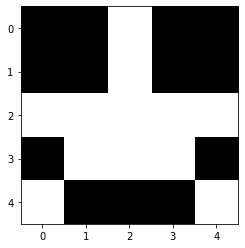

In [102]:
# MAC Problema 1 
solve_problem(0, 'MAC', mac)

Nodes Generated: 11
Nodes Expanded: 11
Time: 0.006235488000129408s


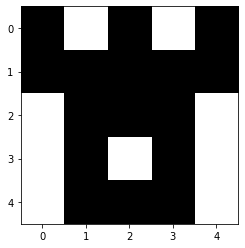

In [103]:
# MAC Problema 2 
solve_problem(1, 'MAC', mac)

Nodes Generated: 21
Nodes Expanded: 21
Time: 0.05559950499991828s


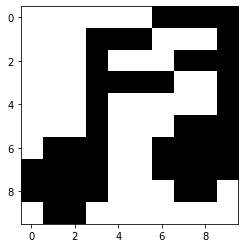

In [104]:
# MAC Problema 3 
solve_problem(2, 'MAC', mac)

Nodes Generated: 31
Nodes Expanded: 31
Time: 0.4621907419996205s


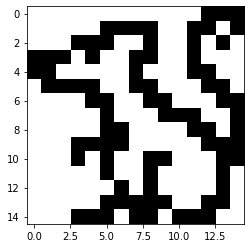

In [105]:
# MAC Problema 4 
solve_problem(3, 'MAC', mac)

Nodes Generated: 36
Nodes Expanded: 36
Time: 0.7792275669999071s


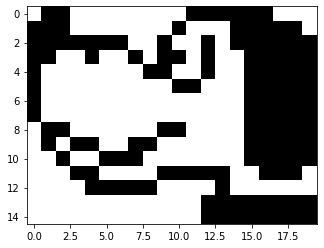

In [106]:
# MAC Problema 5 
solve_problem(4, 'MAC', mac)

Nodes Generated: 51
Nodes Expanded: 51
Time: 2.816755761999957s


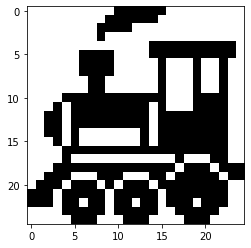

In [107]:
# MAC Problema 6 
solve_problem(5, 'MAC', mac)

## BONUS
### Utilizarea euristicilor in rezolvarea problemei satisfacerii restrictiilor: ordonarea variabilelor
### Minimum remaining value

In [148]:
def bkt_mac_minimum_remaining_value(problem, Vars, Solution, Domains):
    if not Vars:
        return (True, Solution, 1)
    
    # find variable with the the smallest domain (fail first)
    minim = len(Domains[Vars[0]])
    index = 0
    for i in range(len(Vars)):
        if len(Domains[Vars[i]]) < minim:
            minim = len(Domains[Vars[i]])
            index = i
            
    X = Vars[index]
    expanded = 1
    
    for val in Domains[X]:
        new_Domains = deepcopy(Domains)
        if ac3(problem, new_Domains, Solution, X, val):
            new_Vars = Vars[:]
            new_Vars.pop(index)
            
            new_Solution = deepcopy(Solution)
            new_Solution[X] = val
            
            (return_value, return_Solution, return_expanded) = bkt_mac_minimum_remaining_value(problem, new_Vars, new_Solution, new_Domains)
            expanded += return_expanded
            
            if return_value:
                return (return_value, return_Solution, expanded)
    
    return (False, {}, 1)

def mac_minimum_remaining_value(problem):
    (Vars, Domains) = generate_csp(problem)
    
    ac3_begin(problem, Domains)
    (_, solution, expanded) = bkt_mac_minimum_remaining_value(problem, Vars, {}, Domains)
    return (expanded, expanded, [solution[(LINE, i)] for i in range(problem[HEIGHT])])

Nodes Generated: 11
Nodes Expanded: 11
Time: 0.0018880940042436123s


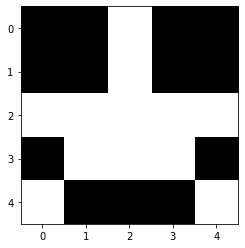

In [149]:
# BONUS MAC Problema 1 
solve_problem(0, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)

Nodes Generated: 11
Nodes Expanded: 11
Time: 0.001584135985467583s


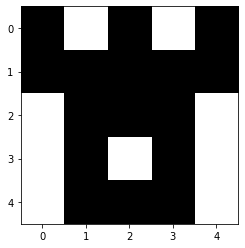

In [150]:
# BONUS MAC Problema 2 
solve_problem(1, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)

Nodes Generated: 21
Nodes Expanded: 21
Time: 0.009780352003872395s


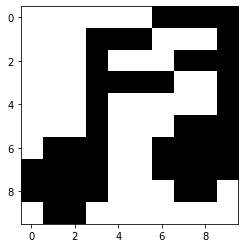

In [151]:
# BONUS MAC Problema 3 
solve_problem(2, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)

Nodes Generated: 31
Nodes Expanded: 31
Time: 0.20478225100669079s


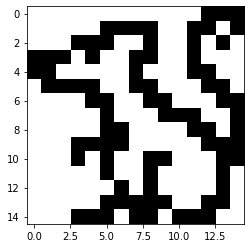

In [152]:
# BONUS MAC Problema 4 
solve_problem(3, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)

Nodes Generated: 36
Nodes Expanded: 36
Time: 0.4630339299910702s


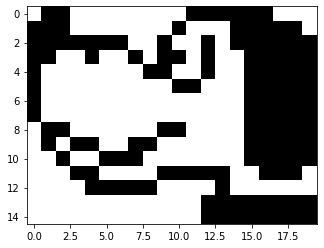

In [153]:
# BONUS MAC Problema 5 
solve_problem(4, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)

Nodes Generated: 51
Nodes Expanded: 51
Time: 2.2687129770056345s


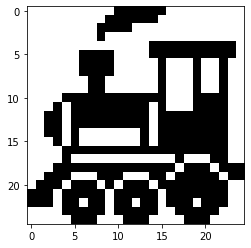

In [154]:
# BONUS MAC Problema 6 
solve_problem(5, 'MAC Minimum Remaining Value', mac_minimum_remaining_value)